<a href="https://colab.research.google.com/github/ndd176/thuchanh1/blob/main/UK_handsign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0 Checking the environment


##0.1 GPU Info

In [ ]:
!nvidia-smi

##0.2 RAM Info

In [ ]:
!grep MemTotal /proc/meminfo

#1 Preparing dataset


##1.1 Download the dataset


In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#https://drive.google.com/file/d/1v0sCkuxIuL7uy8P_mfqOpYYKtsr_0um0/view?usp=sharing
!gdown 1v0sCkuxIuL7uy8P_mfqOpYYKtsr_0um0

Downloading...
From: https://drive.google.com/uc?id=1v0sCkuxIuL7uy8P_mfqOpYYKtsr_0um0
To: /content/kaggle.json
100% 66.0/66.0 [00:00<00:00, 89.3kB/s]


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download kapillondhe/american-sign-language

100% 4.62G/4.64G [00:24<00:00, 194MB/s]
100% 4.64G/4.64G [00:25<00:00, 199MB/s]


In [7]:
!mkdir handsign_photo 

In [8]:
!unzip american-sign-language.zip -d handsign_photo

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: handsign_photo/ASL_Dataset/Train/Z/1897.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1898.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1899.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/19.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/190.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1900.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1901.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1902.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1903.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1904.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1905.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1906.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1907.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1908.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/1909.jpg  
  inflating: handsign_photo/ASL_Dataset/Train/Z/191.jpg  
  i

##1.2 Import libraries

In [9]:
# Basic
import os
import glob
import numpy as np

# Data Viz
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Tensorflow for machine learning
import tensorflow as tf
import tensorflow.keras.utils as utils
import tensorflow.keras.applications as app
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout
from keras.models import load_model

# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping


# Classification models
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1 
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, InceptionV3, Xception, \
        ResNet152, ResNet152V2, MobileNetV3Large,MobileNetV3Small


##1.3 Explore the dataset

###1.3.1 Get list of class names

In [11]:
path_to_data='/content/handsign_photo/ASL_Dataset/Train'
class_names = list(filter(lambda f: os.path.isdir(os.path.join(path_to_data, f)), os.listdir(path_to_data)))
class_names = sorted(class_names)
num_classes = len(class_names)
print(f"Class Names: \n{class_names}")
print(f"Total Number of Classes : {num_classes}")

Class Names: 
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Nothing', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Total Number of Classes : 28


###1.3.2 Viz the classes' distribution





In [12]:
class_dis = [len(os.listdir(path_to_data + f"/{name}")) for name in class_names]
lk_dis = dict(zip(class_names, class_dis))
print(f"Class Distribution : \n{lk_dis}")

fig = px.pie(names=class_names, values=class_dis, width=600)
fig.update_layout({"title":{'text':"Class Distribution","x":0.5}})
fig.show()

Class Distribution : 
{'A': 5996, 'B': 5996, 'C': 5996, 'D': 5996, 'E': 5996, 'F': 5996, 'G': 5996, 'H': 5996, 'I': 5996, 'J': 5996, 'K': 5996, 'L': 5996, 'M': 5996, 'N': 5996, 'Nothing': 5996, 'O': 5996, 'P': 5996, 'Q': 5996, 'R': 5966, 'S': 5996, 'Space': 5886, 'T': 5648, 'U': 4542, 'V': 5996, 'W': 5996, 'X': 5996, 'Y': 5720, 'Z': 5996}


###1.3.3 Show some pictures

Found 165670 files belonging to 28 classes.


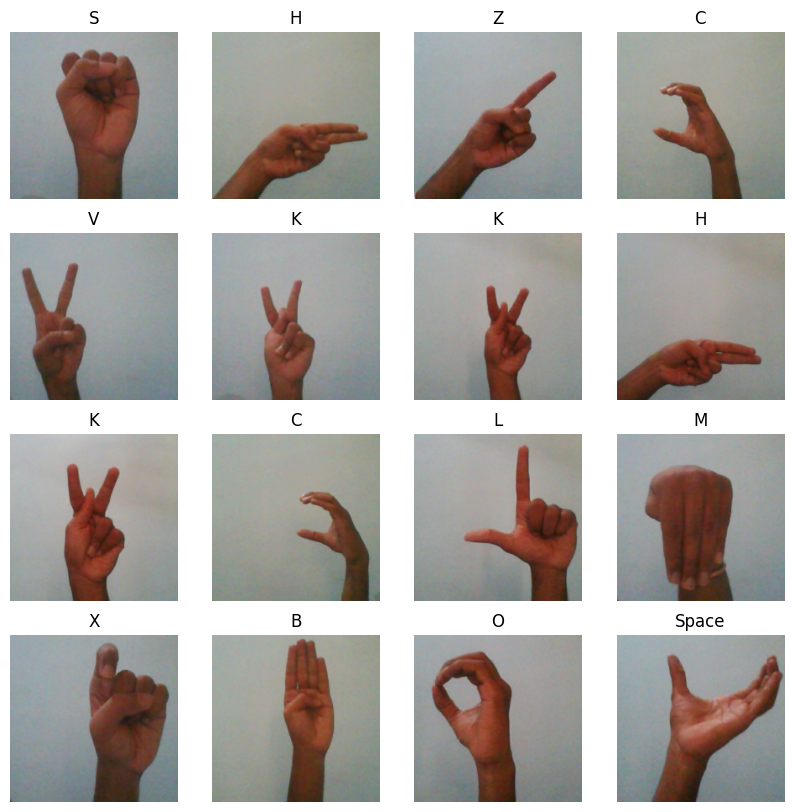

In [13]:
dataset = tf.keras.utils.image_dataset_from_directory(
  path_to_data,
  image_size=(200, 200),
  batch_size=16,
  shuffle=True)

def show_images(dataset):
  plt.figure(figsize=(10,10))
  for images, labels in dataset.take(1):
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      ax.imshow(images[i].numpy().astype("uint8"))
      ax.set_title(dataset.class_names[labels[i]])
      ax.axis("off")
  plt.show()

show_images(dataset)

##1.4 Define utilities and select a backbone

In [14]:
feature_extractor = {
    "VGG16": VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    "ResNet50": ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    "InceptionV3": InceptionV3(include_top=False, input_shape=(299, 299, 3), weights='imagenet')

}
preprocess_methods = {
    "VGG16": app.vgg16.preprocess_input,
    "ResNet50": app.resnet50.preprocess_input,
    "InceptionV3": app.inception_v3.preprocess_input
}
input_sizes = {
    "VGG16": (224, 224),
    "ResNet50": (224, 224),
    "InceptionV3": (299, 299)
}

#################################################################################
## Specify the backbone that will be used in the following cells
#################################################################################
backbone = "ResNet50" # change this if needed
batch_size = 32

87910968/87910968 [==============================] - 1s 0us/step


##1.5 Create a trainning and a test set

In [15]:
generator = ImageDataGenerator(
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=20, 
    validation_split=0.2,
    preprocessing_function=preprocess_methods[backbone])

train_set = generator.flow_from_directory(
    path_to_data, 
    target_size=input_sizes[backbone], 
    class_mode='binary', 
    batch_size= batch_size, 
    shuffle=True, 
    subset='training')

valid_set = generator.flow_from_directory(
    path_to_data, 
    target_size=input_sizes[backbone], 
    class_mode='binary', 
    batch_size= batch_size, 
    shuffle=True, 
    subset='validation')


Found 132542 images belonging to 28 classes.
Found 33128 images belonging to 28 classes.


In [16]:
train_set.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'Nothing': 14,
 'O': 15,
 'P': 16,
 'Q': 17,
 'R': 18,
 'S': 19,
 'Space': 20,
 'T': 21,
 'U': 22,
 'V': 23,
 'W': 24,
 'X': 25,
 'Y': 26,
 'Z': 27}

#2 Defining prediction model

##2.1 Create the model architecture

In [17]:
def create_model(backbone):
  fextractor = feature_extractor[backbone]
  fextractor.trainable = False 

  model = keras.Sequential([
      fextractor,
      GAP(),
      Dense(num_classes, activation='softmax')
  ], name=backbone)
  return model

model = create_model(backbone)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 28)                57372     
                                                                 
Total params: 23,645,084
Trainable params: 57,372
Non-trainable params: 23,587,712
_________________________________________________________________


##2.2 Train and save the created model

In [18]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.95,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule)


model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer=optimizer,
     metrics=['accuracy']
 )

#Callbacks 
cbs = [
     EarlyStopping(patience=3, restore_best_weights=True),
     ModelCheckpoint(backbone + ".h5", save_best_only=True)
 ]

#rain Model
history = model.fit(
     train_set, validation_data=valid_set,
     callbacks=cbs,
     epochs=10, 
     verbose=2
)


Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
# list all data in history
print("Training History:")
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


##2.3 Load and evaluate the trained model

In [ ]:
model_file = "./{:s}.h5".format(backbone)
trained_model = load_model(model_file)
trained_model.evaluate(valid_set)

#3 Predicting and showing the result for some images

##3.1 Load test-set

In [ ]:
test_generator = ImageDataGenerator()
test_set = test_generator.flow_from_directory(
    path_to_data, # Assume that this is test-set
    target_size=input_sizes[backbone], 
    class_mode='binary', 
    batch_size= batch_size, 
    shuffle=True) # should be False in real apps

##3.2 Predict images in a batch and show the results

In [ ]:
def show_prediction(dataset, model, backbone):
  for images, labels in dataset:
    print(images.dtype, images.min(), images.max())
    preprocess = preprocess_methods[backbone]
    batch = preprocess(images.copy())
    probs = model.predict(batch)

    pred_labels = probs.argmax(axis=-1)
    pred_labels = [class_names[idx] for idx in pred_labels]
    ori_labels = [class_names[int(idx)] for idx in labels]

    fig = plt.figure(figsize=(16,16), layout='constrained')
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      ax.imshow(images[i].astype(np.uint8))
      title = "predicted: {:s}({:s})".format(pred_labels[i], ori_labels[i])
      ax.set_title(title)
      ax.axis("off")
    fig.suptitle("Prediction results for images in a batch")
    plt.show()
    break

show_prediction(test_set, trained_model, backbone)